In [1]:
# @title HuggingFace Datasets
from datasets import load_dataset
from datasets import load_dataset_builder
from datasets import get_dataset_split_names
from datasets import get_dataset_config_names

print(get_dataset_config_names("tiny_shakespeare"), end="\n\n")
print(get_dataset_split_names("tiny_shakespeare"), end="\n\n")
print(load_dataset("tiny_shakespeare", split="train"), end="\n\n")
print(load_dataset("tiny_shakespeare", "default", split="train"), end="\n\n")
print(load_dataset_builder("tiny_shakespeare").info.description, end="\n\n")

['default']

['train', 'validation', 'test']

Dataset({
    features: ['text'],
    num_rows: 1
})

Dataset({
    features: ['text'],
    num_rows: 1
})

40,000 lines of Shakespeare from a variety of Shakespeare's plays. Featured in Andrej Karpathy's blog post 'The Unreasonable Effectiveness of Recurrent Neural Networks': http://karpathy.github.io/2015/05/21/rnn-effectiveness/.

To use for e.g. character modelling:

```
d = datasets.load_dataset(name='tiny_shakespeare')['train']
d = d.map(lambda x: datasets.Value('strings').unicode_split(x['text'], 'UTF-8'))
# train split includes vocabulary for other splits
vocabulary = sorted(set(next(iter(d)).numpy()))
d = d.map(lambda x: {'cur_char': x[:-1], 'next_char': x[1:]})
d = d.unbatch()
seq_len = 100
batch_size = 2
d = d.batch(seq_len)
d = d.batch(batch_size)
```




In [2]:
# @title HuggingFace Tokenizers
from datasets import load_dataset
from transformers import AutoTokenizer
from tokenizers.pre_tokenizers import WhitespaceSplit

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
output = tokenizer.encode("Welcome to the 🤗 Tokenizers library.")
encoding = tokenizer("We are very happy to show you the 🤗 Transformers library.")
print(output, end="\n\n")
print(tokenizer.decode(output), end="\n\n")
print(encoding, end="\n\n")

[101, 6160, 2000, 1996, 100, 19204, 17629, 2015, 3075, 1012, 102]

[CLS] welcome to the [UNK] tokenizers library. [SEP]

{'input_ids': [101, 2057, 2024, 2200, 3407, 2000, 2265, 2017, 1996, 100, 19081, 3075, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}



In [3]:
def pre_tokenize_and_chunk(
    text, max_length=510
):  # slightly less than 512 to account for special tokens
    pre_tokenizer = WhitespaceSplit()
    pre_tokens = pre_tokenizer.pre_tokenize_str(text)

    chunks = []
    current_chunk = ""
    for token, (start, end) in pre_tokens:
        if len(current_chunk) + len(token) + 1 > max_length:
            chunks.append(current_chunk)
            current_chunk = token
        else:
            current_chunk += " " + token if current_chunk else token
    if current_chunk:
        chunks.append(current_chunk)

    return chunks


def tokenize_and_chunk(examples):
    tokenized_batches = {"text": [], "input_ids": [], "attention_mask": []}

    for text in examples["text"]:
        chunks = pre_tokenize_and_chunk(text)
        for chunk in chunks:
            tokenized_output = tokenizer(
                chunk,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors="pt",
            )
            tokenized_batches["text"].append(chunk)
            tokenized_batches["input_ids"].append(
                tokenized_output["input_ids"][0].tolist()
            )
            tokenized_batches["attention_mask"].append(
                tokenized_output["attention_mask"][0].tolist()
            )

    return tokenized_batches

In [4]:
# Load the dataset
text_dataset = load_dataset("tiny_shakespeare")
print(text_dataset, end="\n\n")
print(
    "train:",
    type(text_dataset["train"]["text"]),
    len(text_dataset["train"]["text"]),
    type(text_dataset["train"]["text"][0]),
    len(text_dataset["train"]["text"][0]),
    end="\n\n",
)
print(
    "validation:",
    type(text_dataset["validation"]["text"]),
    len(text_dataset["validation"]["text"]),
    type(text_dataset["validation"]["text"][0]),
    len(text_dataset["validation"]["text"][0]),
    end="\n\n",
)
print(
    "test:",
    type(text_dataset["test"]["text"]),
    len(text_dataset["test"]["text"]),
    type(text_dataset["test"]["text"][0]),
    len(text_dataset["test"]["text"][0]),
    end="\n\n",
)

# Apply the tokenization and chunking to each split
text_dataset = text_dataset.map(tokenize_and_chunk, batched=True)
print(text_dataset, end="\n\n")
print(text_dataset["train"]["text"][0], end="\n\n")
print(tokenizer.decode(text_dataset["train"]["input_ids"][0]), end="\n\n")

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 1
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1
    })
})

train: <class 'list'> 1 <class 'str'> 1003854

validation: <class 'list'> 1 <class 'str'> 55770

test: <class 'list'> 1 <class 'str'> 55770

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 1963
    })
    validation: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 109
    })
    test: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 109
    })
})

First Citizen: Before we proceed any further, hear me speak. All: Speak, speak. First Citizen: You are all resolved rather to die than to famish? All: Resolved. resolved. First Citizen: First, you know Caius Marcius is chief enemy to the people. All: We know'

In [5]:
# @title PyTorch nn.Embedding
import torch

#  Create an embedding layer
embedding_dim = 302
embedding = torch.nn.Embedding(
    num_embeddings=tokenizer.vocab_size, embedding_dim=embedding_dim, dtype=torch.half
)

In [6]:
# @title Synthetic dataset where neural activity is sequence of token embeddings
import random
import nbimporter
import numpy as np
from utils import NEURONS_302
from preprocess._utils import smooth_data_preprocess, reshape_calcium_data

train_tokens = text_dataset["train"]["input_ids"]
validation_tokens = text_dataset["validation"]["input_ids"]
test_tokens = text_dataset["test"]["input_ids"]
all_tokens = train_tokens + validation_tokens + test_tokens
worm_dataset = dict()
max_timesteps = 3000
num_signals = embedding_dim
num_named_neurons = 50
num_unknown_neurons = num_signals - num_named_neurons
smooth_method = None
dataset_name = "Shakespeare0000"

worm_idx = 0
calcium_data = []
total_time = 0
for chunk in all_tokens:
    if worm_idx > 200:
        break

    embd_data = embedding(torch.LongTensor(chunk)).detach().numpy()
    calcium_data.append(embd_data)
    total_time += embd_data.shape[0]
    if total_time >= max_timesteps:
        calcium_data = np.vstack(calcium_data)
        time_in_seconds = np.arange(total_time).reshape(-1, 1)
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = np.finfo(float).eps
        resample_dt = np.round(np.median(dt).item(), 2)
        residual_calcium = np.gradient(calcium_data, axis=0) / dt
        smooth_calcium_data = smooth_data_preprocess(
            calcium_data, time_in_seconds, smooth_method
        )
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium, time_in_seconds, smooth_method
        )
        named_neuron_indices = random.sample(range(num_signals), num_named_neurons)
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        worm_data = dict()

        worm_data["worm"] = f"worm{worm_idx}"
        worm_data["dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["calcium_data"] = calcium_data
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["max_timesteps"] = total_time
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["resample_median_dt"] = resample_dt
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signals
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        worm_data = reshape_calcium_data(worm_data)
        worm_dataset[f"worm{worm_idx}"] = worm_data

        worm_idx += 1
        calcium_data = []
        total_time = 0

CUDA device found.


In [7]:
print(f"{worm_idx}\n {worm_dataset.keys()}", end="\n\n")
for worm in worm_dataset:
    print(worm_dataset[worm]["calcium_data"].shape)

95
 dict_keys(['worm0', 'worm1', 'worm2', 'worm3', 'worm4', 'worm5', 'worm6', 'worm7', 'worm8', 'worm9', 'worm10', 'worm11', 'worm12', 'worm13', 'worm14', 'worm15', 'worm16', 'worm17', 'worm18', 'worm19', 'worm20', 'worm21', 'worm22', 'worm23', 'worm24', 'worm25', 'worm26', 'worm27', 'worm28', 'worm29', 'worm30', 'worm31', 'worm32', 'worm33', 'worm34', 'worm35', 'worm36', 'worm37', 'worm38', 'worm39', 'worm40', 'worm41', 'worm42', 'worm43', 'worm44', 'worm45', 'worm46', 'worm47', 'worm48', 'worm49', 'worm50', 'worm51', 'worm52', 'worm53', 'worm54', 'worm55', 'worm56', 'worm57', 'worm58', 'worm59', 'worm60', 'worm61', 'worm62', 'worm63', 'worm64', 'worm65', 'worm66', 'worm67', 'worm68', 'worm69', 'worm70', 'worm71', 'worm72', 'worm73', 'worm74', 'worm75', 'worm76', 'worm77', 'worm78', 'worm79', 'worm80', 'worm81', 'worm82', 'worm83', 'worm84', 'worm85', 'worm86', 'worm87', 'worm88', 'worm89', 'worm90', 'worm91', 'worm92', 'worm93', 'worm94'])

torch.Size([3036, 302])
torch.Size([3033, 3

In [8]:
from CreateSyntheticDataset import save_synthetic_dataset

# Save the dataset
save_synthetic_dataset(f"processed/neural/{dataset_name}.pickle", worm_dataset)

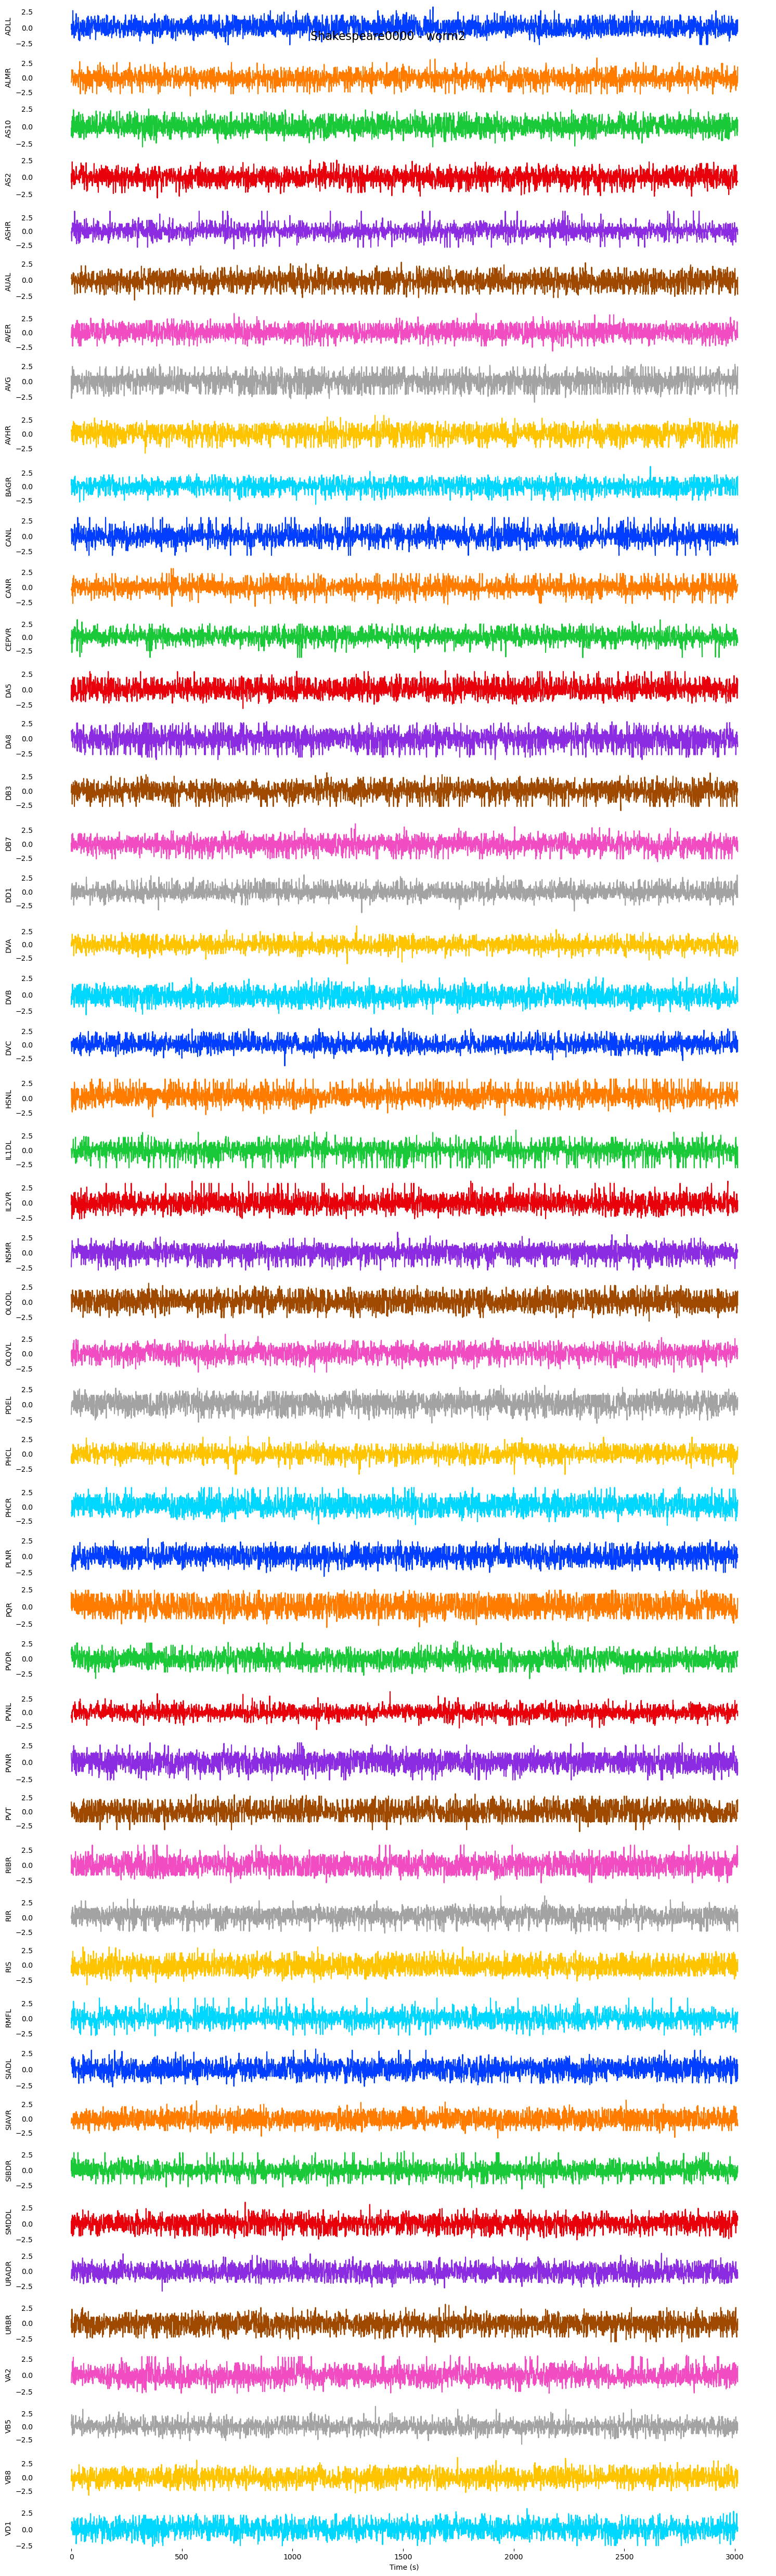

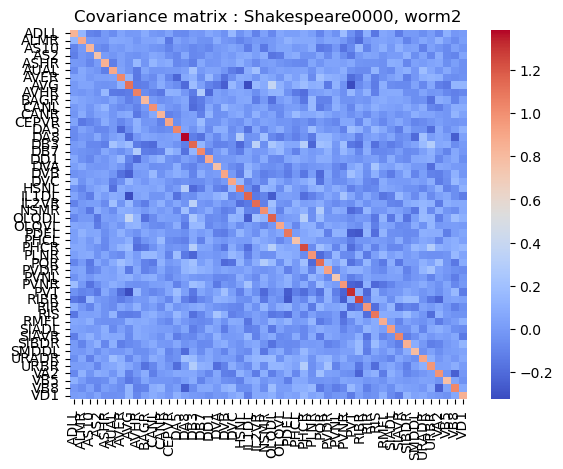

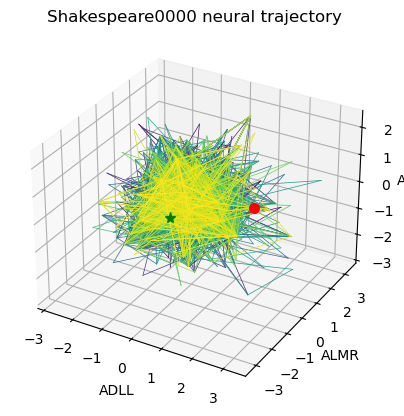

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from CreateSyntheticDataset import plot_neural_signals, plot_3d_trajectory

# Selecting a worm and all the neurons to plot
num_worms = len(worm_dataset)
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in worm_dataset[worm_idx]["slot_to_neuron"].keys()][
    :num_named_neurons
]

# Plotting dataset
plot_neural_signals(
    data=worm_dataset[worm_idx]["calcium_data"],
    time_tensor=worm_dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle=f"{dataset_name} - {worm_idx}",
)

# Visualize covariance matrix
data = worm_dataset[worm_idx]["smooth_calcium_data"]
mask = worm_dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(worm_dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {dataset_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(
    X, axis_labels=tuple(neurons), title=f"{dataset_name} neural trajectory"
)

In [11]:
### DEBUG: Quantizing? ###
_ = [tuple(X[i, :]) for i in range(X.shape[0])]
print(X.dtype, len(_), len(set(_)))
### DEBUG: Quantizing? ###

float16 3013 831


In [7]:
# def create_synthetic_dataset_shakespeare(
#     max_timesteps: int = 1000,
#     num_worms: int = 1,
#     num_signals: int = 302,
#     num_named_neurons: int = 1,
#     add_noise: bool = False,
#     noise_std: float = 0.01,
#     random_walk: bool = False,
#     random_freqs: bool = False,
#     delta_seconds: float = 0.5,
#     dataset_name: str = "Shakespeare0000",
# ):
#     return None